# Automatic Ticket Assignment - Capstone Project - Approach1

## Problem Statement - 

In most of the IT organizations, the assignment of incidents to appropriate IT groups is still a manual process. Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service. 

_<font color=blue>This capstone project intends to reduce the manual intervention of IT operations or Service desk teams by automating the ticket assignment process.The goal here is to create a text classification based ML model that can automatically  classify any new tickets by analysing ticket description to one of the relevant Assignment groups, which could be later integrated to any ITSM tool like Service Now. Based on the ticket description our model will output the probability of assigning it to one of the 74 Groups.</font>_

The solution would be implemented using below approach:
- Approach 1 - Using a traditional machine learning algorithm we would be classifying the tickets into one of the groups having more than 100 tickets.


### Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df_tranlated_inc = pd.read_csv('dataset/processed_file_modellling.csv',encoding='utf-8')
df_tranlated_inc.head()

,Assignment_group,Target,cleaned_description,num_wds,avg_word,uniq_wds,token_desc
0,GRP_0,L1/L2,login issue verified user detailsemployee mana...,20,6.900000,17,login issue verified user detailsemployee mana...
1,GRP_0,L1/L2,outlook hmjdrvpbkomuaywn teammy meetingsskype ...,12,8.083333,11,outlook hmjdrvpbkomuaywn teammy meetingsskype ...
2,GRP_0,L1/L2,cant log vpn eylqgodmybqkwiami cannot log vpn,7,5.571429,5,cant log vpn eylqgodmybqkwiami cannot log vpn
3,GRP_0,L1/L2,unable access hrtool page unable access hrtool...,8,5.500000,4,unable access hrtool page unable access hrtool...
4,GRP_0,L1/L2,skype error skype error,4,5.000000,2,skype error skype error


## Modeling

In [3]:
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [4]:
df_inc_sample = df_tranlated_inc[df_tranlated_inc['Assignment_group'].map(df_tranlated_inc['Assignment_group'].value_counts()) > 100]
x = df_inc_sample['token_desc']
y = df_inc_sample['Assignment_group']

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y)
y = encoder.transform(y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13,stratify=y)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]
    
log_cols=["Classifier", "accuracy","f1_score"]
log = pd.DataFrame(columns=log_cols)

In [5]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

### Naive Bayes classifier for multinomial models

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

predictions = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test)) 
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["MultinomialNB",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.6588486140724946
f1 score 0.7755462017592144
logloss: 1.328 
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       794
           1       0.00      0.00      0.00        28
           2       0.82      0.18      0.30        50
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        44
           6       0.75      0.06      0.11        49
           7       1.00      0.14      0.24        58
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        40
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        31
          12       0.00      0.00      0.00        37
          13       0.53      0.87      0.65       129
          14       1.00      0.02      0.04        51

    accuracy                           0.66      1407
   macro

### Linear support vector machine


In [8]:
from sklearn.svm import LinearSVC

svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(loss='hinge',random_state=42,class_weight='balanced'))),
               ])
svc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                         class_weight='balanced',
       

In [9]:
y_pred = svc.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print (focal_loss(alpha=.25, gamma=2))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7974413646055437
f1 score 0.7971002817664733
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       794
           1       0.80      0.71      0.75        28
           2       0.52      0.70      0.60        50
           3       0.78      0.62      0.69        29
           4       0.43      0.39      0.41        23
           5       0.36      0.36      0.36        44
           6       0.54      0.61      0.57        49
           7       0.87      0.79      0.83        58
           8       0.61      0.61      0.61        23
           9       0.45      0.47      0.46        40
          10       0.64      0.43      0.51        21
          11       0.82      0.58      0.68        31
          12       0.81      0.78      0.79        37
          13       0.80      0.89      0.84       129
          14       0.93      0.73      0.81        51

    accuracy                           0.80      1407
   macro avg       0.68 

In [10]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None,class_weight='balanced')),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 SGDClassifier(alpha=0.001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                               loss='hinge', max_iter=

In [11]:
y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))
log_entry = pd.DataFrame([["SGDClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.728500355366027
f1 score 0.7088474757055361
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       794
           1       0.67      0.86      0.75        28
           2       0.45      0.66      0.53        50
           3       0.37      0.72      0.49        29
           4       0.38      0.74      0.50        23
           5       0.34      0.34      0.34        44
           6       0.48      0.61      0.54        49
           7       0.65      0.74      0.69        58
           8       0.40      0.74      0.52        23
           9       0.42      0.50      0.45        40
          10       0.27      0.62      0.38        21
          11       0.62      0.68      0.65        31
          12       0.59      0.78      0.67        37
          13       0.94      0.73      0.82       129
          14       0.74      0.73      0.73        51

    accuracy                           0.73      1407
   macro avg       0.55  

### Logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression

logreg_1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')),
               ])
logreg_1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight='balanced',
                                    dual=False, fit_intercept=True,
             

In [13]:
y_pred = logreg_1.predict(X_test)
predictions = logreg_1.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))
log_entry = pd.DataFrame([["LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7882018479033405
f1 score 0.7923411421901295
logloss: 2.231 
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       794
           1       0.85      0.61      0.71        28
           2       0.56      0.62      0.59        50
           3       0.73      0.66      0.69        29
           4       0.50      0.48      0.49        23
           5       0.33      0.30      0.31        44
           6       0.56      0.57      0.57        49
           7       0.81      0.83      0.82        58
           8       0.68      0.57      0.62        23
           9       0.47      0.38      0.42        40
          10       0.45      0.43      0.44        21
          11       0.76      0.52      0.62        31
          12       0.72      0.78      0.75        37
          13       0.84      0.84      0.84       129
          14       0.92      0.71      0.80        51

    accuracy                           0.79      1407
   macro

### Xgboost

In [14]:
import xgboost as xgb

xgboost = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)),
               ])
xgboost.fit(X_train, y_train,clf__sample_weight=w_array)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=10, nthread=10, 

In [15]:
y_pred = xgboost.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["Xgboost",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.681592039800995
f1 score 0.6613709885634036
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       794
           1       0.18      0.64      0.29        28
           2       0.36      0.62      0.45        50
           3       0.57      0.59      0.58        29
           4       0.38      0.52      0.44        23
           5       0.30      0.55      0.39        44
           6       0.43      0.47      0.45        49
           7       0.70      0.78      0.74        58
           8       0.64      0.61      0.62        23
           9       0.34      0.50      0.41        40
          10       0.44      0.38      0.41        21
          11       0.56      0.29      0.38        31
          12       0.75      0.32      0.45        37
          13       0.82      0.60      0.69       129
          14       0.57      0.41      0.48        51

    accuracy                           0.68      1407
   macro avg       0.53  

## Hyperparameter Tune GridSearchCV

### LinearSVC

In [16]:
from sklearn.model_selection import GridSearchCV

params = {"clf__estimator__C": [0.1, 1, 10, 100, 1000],  
              'clf__estimator__loss': ['hinge','squared_hinge'],}  
  
clf_svc = GridSearchCV(svc, param_grid=params, refit = True, verbose = 1,scoring='f1_weighted') 
# fitting the model for grid search 
clf_svc.fit(X_train, y_train)

print("Best Score: ", clf_svc.best_score_)
print("Best Params: ", clf_svc.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   41.0s finished


Best Score:  0.7943364733949457
Best Params:  {'clf__estimator__C': 1, 'clf__estimator__loss': 'hinge'}


In [17]:
y_pred = clf_svc.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC_best_estimator_gcv",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7974413646055437
f1 score 0.7971002817664733
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       794
           1       0.80      0.71      0.75        28
           2       0.52      0.70      0.60        50
           3       0.78      0.62      0.69        29
           4       0.43      0.39      0.41        23
           5       0.36      0.36      0.36        44
           6       0.54      0.61      0.57        49
           7       0.87      0.79      0.83        58
           8       0.61      0.61      0.61        23
           9       0.45      0.47      0.46        40
          10       0.64      0.43      0.51        21
          11       0.82      0.58      0.68        31
          12       0.81      0.78      0.79        37
          13       0.80      0.89      0.84       129
          14       0.93      0.73      0.81        51

    accuracy                           0.80      1407
   macro avg       0.68 

### SGD Classifier

In [18]:
params = {
    "clf__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "clf__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "clf__penalty" : ["l2", "l1", "none"],
}

clf_sgd = GridSearchCV(sgd, param_grid=params,refit = True, verbose = 1,scoring='f1_weighted')
clf_sgd.fit(X_train, y_train)

print("Best Score: ", clf_sgd.best_score_)
print("Best Params: ", clf_sgd.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  3.5min finished


Best Score:  0.7909050333862092
Best Params:  {'clf__alpha': 0.0001, 'clf__loss': 'modified_huber', 'clf__penalty': 'l2'}


In [19]:
y_pred = clf_sgd.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["SGD_best_estimator_gcv",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7924662402274343
f1 score 0.7874501781073971
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       794
           1       0.76      0.79      0.77        28
           2       0.51      0.66      0.57        50
           3       0.70      0.66      0.68        29
           4       0.48      0.61      0.54        23
           5       0.36      0.36      0.36        44
           6       0.49      0.63      0.55        49
           7       0.83      0.84      0.84        58
           8       0.58      0.61      0.60        23
           9       0.48      0.55      0.51        40
          10       0.45      0.48      0.47        21
          11       0.57      0.55      0.56        31
          12       0.75      0.81      0.78        37
          13       0.89      0.84      0.86       129
          14       0.87      0.76      0.81        51

    accuracy                           0.79      1407
   macro avg       0.64 

### Logistic Regression

In [20]:
params = {
  'clf__penalty': ['l2'],
  'clf__C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0,1e2,1e4,1e5],
  'clf__max_iter': [100,4000,5000],
}

clf_lr = GridSearchCV(logreg_1, param_grid=params,refit = True,verbose = 1,scoring='f1_weighted')
clf_lr.fit(X_train, y_train)

print("Best Score: ", clf_lr.best_score_)
print("Best Params: ", clf_lr.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 15.5min finished


Best Score:  0.7833517320435001
Best Params:  {'clf__C': 100.0, 'clf__max_iter': 4000, 'clf__penalty': 'l2'}


In [21]:
y_pred = clf_lr.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression_best_estimator_gcv",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7882018479033405
f1 score 0.7843872551896391
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       794
           1       0.81      0.75      0.78        28
           2       0.53      0.62      0.57        50
           3       0.73      0.66      0.69        29
           4       0.42      0.48      0.45        23
           5       0.31      0.34      0.33        44
           6       0.53      0.65      0.59        49
           7       0.84      0.83      0.83        58
           8       0.59      0.70      0.64        23
           9       0.42      0.47      0.45        40
          10       0.45      0.48      0.47        21
          11       0.68      0.55      0.61        31
          12       0.73      0.81      0.77        37
          13       0.87      0.84      0.85       129
          14       0.91      0.78      0.84        51

    accuracy                           0.79      1407
   macro avg       0.65 

### Word2vec embedding and Logistic Regression


Let's use pretrined glove embeddings to train the model 

In [22]:
import logging
import nltk
from gensim.models import Word2Vec
import gensim

In [23]:
wv = gensim.models.KeyedVectors.load_word2vec_format("dataset/glove.6B/glove.6B.100d.w2vformat.txt")
wv.init_sims(replace=True)

In [24]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [25]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [26]:
df_inc_sample.head()

,Assignment_group,Target,cleaned_description,num_wds,avg_word,uniq_wds,token_desc
0,GRP_0,L1/L2,login issue verified user detailsemployee mana...,20,6.900000,17,login issue verified user detailsemployee mana...
1,GRP_0,L1/L2,outlook hmjdrvpbkomuaywn teammy meetingsskype ...,12,8.083333,11,outlook hmjdrvpbkomuaywn teammy meetingsskype ...
2,GRP_0,L1/L2,cant log vpn eylqgodmybqkwiami cannot log vpn,7,5.571429,5,cant log vpn eylqgodmybqkwiami cannot log vpn
3,GRP_0,L1/L2,unable access hrtool page unable access hrtool...,8,5.500000,4,unable access hrtool page unable access hrtool...
4,GRP_0,L1/L2,skype error skype error,4,5.000000,2,skype error skype error


In [27]:
# df_tranlated_inc = pd.read_csv("dataset/cleaned_data.csv",encoding='utf-8')
# df_tranlated_inc = df_tranlated_inc.drop(['Unnamed: 0','cleaned_description','language'],axis=1)

#df_inc_sample = df_tranlated_inc[df_tranlated_inc['Assignment group'].map(df_tranlated_inc['Assignment group'].value_counts()) > 100]
#df_inc_sample.rename(columns = {'Assignment group':'Assignment_group'}, inplace = True)


# df_inc_sample = df_inc_sample.sample(frac=1).reset_index(drop=True)

# grp0_sample = df_inc_sample[df_inc_sample['Assignment_group']=='GRP_0'].sample(n=1500)
# other_rows = df_inc_sample[df_inc_sample['Assignment_group']!='GRP_0']
# df_inc_sample = pd.concat([other_rows,grp0_sample]).reset_index(drop=True)

train, test = train_test_split(df_inc_sample, test_size=0.2, random_state = 13,stratify=df_inc_sample['Assignment_group'])

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['token_desc']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['token_desc']), axis=1).values

In [28]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

### Logistic Regression 

In [29]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')
logreg = logreg.fit(X_train_word_average, train['Assignment_group'])
y_pred = logreg.predict(X_test_word_average)

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score
print('accuracy %s' % accuracy_score(y_pred, test.Assignment_group))
print('f1 score %s' % f1_score(y_pred, test.Assignment_group,average='weighted'))
print(classification_report(test.Assignment_group, y_pred))


print(confusion_matrix(test.Assignment_group,y_pred))
log_entry = pd.DataFrame([["Word2Vec - LogisticRegression",accuracy_score(y_pred, test.Assignment_group),f1_score(y_pred, test.Assignment_group,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.46766169154228854
f1 score 0.4156525934808569
              precision    recall  f1-score   support

       GRP_0       0.96      0.49      0.65       794
      GRP_10       0.20      0.36      0.25        28
      GRP_12       0.31      0.52      0.39        50
      GRP_13       0.19      0.34      0.25        29
      GRP_14       0.17      0.39      0.23        23
      GRP_19       0.21      0.50      0.30        44
       GRP_2       0.24      0.69      0.36        49
      GRP_24       0.53      0.72      0.61        58
      GRP_25       0.10      0.22      0.14        23
       GRP_3       0.17      0.35      0.23        40
      GRP_33       0.14      0.33      0.19        21
       GRP_5       0.16      0.77      0.27        31
       GRP_6       0.32      0.38      0.35        37
       GRP_8       0.88      0.34      0.49       129
       GRP_9       0.33      0.08      0.13        51

    accuracy                           0.47      1407
   macro avg       0.33

<b> We see that the performance is very poor than the benchmark model, as the pretrained embedding used is not specific to ITSM data and more related to generic english texts </b>

### Xgboost

In [31]:
xgb_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_clf = xgb_clf.fit(X_train_word_average, train['Assignment_group'],sample_weight=w_array)
y_pred = xgb_clf.predict(X_test_word_average)

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score
print('accuracy %s' % accuracy_score(y_pred, test.Assignment_group))
print('f1 score %s' % f1_score(y_pred, test.Assignment_group,average='weighted'))
print(classification_report(test.Assignment_group, y_pred))

print(confusion_matrix(test.Assignment_group,y_pred))


accuracy 0.6609808102345416
f1 score 0.6897078287081292
              precision    recall  f1-score   support

       GRP_0       0.78      0.92      0.85       794
      GRP_10       0.00      0.00      0.00        28
      GRP_12       0.49      0.36      0.41        50
      GRP_13       0.33      0.24      0.28        29
      GRP_14       0.35      0.26      0.30        23
      GRP_19       0.24      0.14      0.17        44
       GRP_2       0.60      0.51      0.55        49
      GRP_24       0.75      0.71      0.73        58
      GRP_25       0.50      0.22      0.30        23
       GRP_3       0.19      0.10      0.13        40
      GRP_33       0.38      0.14      0.21        21
       GRP_5       0.16      0.74      0.26        31
       GRP_6       0.32      0.30      0.31        37
       GRP_8       0.89      0.36      0.52       129
       GRP_9       1.00      0.02      0.04        51

    accuracy                           0.66      1407
   macro avg       0.46 

### Doc2vec and Logistic Regression

Let's try using Doc2vec, doc2vec is an extension to the word2vec-approach towards documents. Its intention is encode (whole) docs, consisting of lists of sentences, rather than lists of ungrouped sentences. 

There are two approaches in Doc2vec:
    - Distributed Memory
    - Distributed BOW

In [33]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [34]:

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), tags=[label]))
    return labeled

In [35]:

X_train, X_test, y_train, y_test  = train_test_split(df_inc_sample.token_desc, df_inc_sample.Assignment_group, test_size=0.2, random_state = 13,stratify=df_inc_sample['Assignment_group'])
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test



from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]

In [36]:
X_train[:2]

[TaggedDocument(words=['unable', 'login', 'collaborationplatform', 'unable', 'login', 'collaborationplatform'], tags=['Train_0']),
 TaggedDocument(words=['hostname66volume', 'f', 'labeldat1hostname66', '9a625d75', 'server', '85', 'space', 'consumed', 'space', 'available', '648', 'k', 'volume', 'f', 'labeldat1hostname66', '9a625d75', 'server', '85', 'space', 'consumed', 'space', 'available', '648', 'k'], tags=['Train_1'])]

### Distributed BOW
DBOW is the doc2vec model analogous to Skip-gram model in word2vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

In [37]:
def train_doc2vec(corpus):
    logging.info('Building Doc2Vec model')
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
    model_dbow.build_vocab(corpus)
    return model_dbow
    

#### Building a Vocabulary

In [38]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|█████████████████████████████████████████████████████████████████████████| 7033/7033 [00:00<00:00, 2349170.98it/s]


In [39]:
#### Training DBOW model for 30 epochs

In [40]:

for epoch in range(40):
    model_dbow.train(utils.shuffle([x for x in all_data]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

#### Building the Final Vector Feature for the Classifier

In [41]:

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [42]:

train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

#### Train the Logistic Regression Classifier.

In [43]:

logreg = LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')
logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [44]:

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred,y_test,average='weighted'))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

log_entry = pd.DataFrame([["Doc2Vec (dbow) - LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred,y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.5678749111584932
f1 score 0.5209679345597619
              precision    recall  f1-score   support

           0       0.95      0.58      0.72       794
           1       0.50      0.61      0.55        28
           2       0.33      0.52      0.40        50
           3       0.48      0.55      0.52        29
           4       0.22      0.48      0.30        23
           5       0.17      0.45      0.25        44
           6       0.29      0.61      0.40        49
           7       0.73      0.79      0.76        58
           8       0.28      0.61      0.38        23
           9       0.17      0.38      0.24        40
          10       0.19      0.52      0.28        21
          11       0.38      0.55      0.45        31
          12       0.36      0.54      0.43        37
          13       0.82      0.54      0.65       129
          14       0.38      0.49      0.43        51

    accuracy                           0.57      1407
   macro avg       0.42 

In [45]:
xgb_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_clf = xgb_clf.fit(train_vectors_dbow, y_train,sample_weight=w_array)
y_pred = xgb_clf.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
#print('f1 score %s' % f1_score(y_pred,y_test,average='weighted'))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

accuracy 0.7484008528784648
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       794
           1       0.63      0.43      0.51        28
           2       0.47      0.54      0.50        50
           3       0.53      0.55      0.54        29
           4       0.39      0.39      0.39        23
           5       0.47      0.32      0.38        44
           6       0.61      0.47      0.53        49
           7       0.80      0.81      0.80        58
           8       0.50      0.39      0.44        23
           9       0.62      0.38      0.47        40
          10       0.55      0.29      0.37        21
          11       0.27      0.13      0.17        31
          12       0.41      0.32      0.36        37
          13       0.68      0.79      0.73       129
          14       0.42      0.31      0.36        51

    accuracy                           0.75      1407
   macro avg       0.55      0.47      0.50      140

### Distributed Memory

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document. We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [46]:

model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=3, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in all_data])

In [47]:
for epoch in range(40):
    model_dm.train(utils.shuffle([x for x in all_data]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

In [48]:

train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [49]:
logreg = logreg.fit(train_vectors_dm, y_train)
y_pred = logreg.predict(test_vectors_dm)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred,y_test,average='weighted'))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

log_entry = pd.DataFrame([["Doc2Vec (dm) - LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred,y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.4214641080312722
f1 score 0.38158314075327643
              precision    recall  f1-score   support

           0       0.88      0.41      0.56       794
           1       0.16      0.46      0.23        28
           2       0.25      0.44      0.32        50
           3       0.40      0.59      0.47        29
           4       0.20      0.43      0.27        23
           5       0.19      0.30      0.23        44
           6       0.25      0.45      0.32        49
           7       0.52      0.74      0.61        58
           8       0.16      0.26      0.20        23
           9       0.24      0.57      0.34        40
          10       0.15      0.43      0.22        21
          11       0.16      0.42      0.23        31
          12       0.16      0.19      0.18        37
          13       0.39      0.43      0.41       129
          14       0.18      0.27      0.22        51

    accuracy                           0.42      1407
   macro avg       0.29

In [50]:
xgb_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_clf = xgb_clf.fit(train_vectors_dm, y_train,sample_weight=w_array)
y_pred = xgb_clf.predict(test_vectors_dm)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred,y_test,average='weighted'))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

accuracy 0.7242359630419332
f1 score 0.75293351364001
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       794
           1       0.60      0.32      0.42        28
           2       0.54      0.52      0.53        50
           3       0.67      0.55      0.60        29
           4       0.32      0.26      0.29        23
           5       0.53      0.20      0.30        44
           6       0.61      0.45      0.52        49
           7       0.81      0.74      0.77        58
           8       0.50      0.22      0.30        23
           9       0.65      0.33      0.43        40
          10       0.50      0.29      0.36        21
          11       0.32      0.19      0.24        31
          12       0.29      0.16      0.21        37
          13       0.59      0.68      0.63       129
          14       0.24      0.14      0.18        51

    accuracy                           0.72      1407
   macro avg       0.53   

### Model Pairing
We also tried combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM) together for evaluation to check if it improves performance. 

In [51]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

#### Concatenate two models with feature vectors

In [52]:
def get_concat_vectors(model1,model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
    return vectors

In [53]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_test), 600, 'Test')

#### Train Logistic Regression Models

In [54]:
logreg = logreg.fit(train_vecs_dbow_dm, y_train)
y_pred = logreg.predict(test_vecs_dbow_dm)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

log_entry = pd.DataFrame([["Doc2Vec (dbow + dm) - LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred,y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.566453447050462
              precision    recall  f1-score   support

           0       0.95      0.60      0.74       794
           1       0.52      0.61      0.56        28
           2       0.33      0.54      0.41        50
           3       0.41      0.62      0.49        29
           4       0.28      0.48      0.35        23
           5       0.16      0.41      0.23        44
           6       0.25      0.57      0.35        49
           7       0.69      0.84      0.76        58
           8       0.26      0.43      0.33        23
           9       0.19      0.40      0.26        40
          10       0.23      0.43      0.30        21
          11       0.30      0.45      0.36        31
          12       0.28      0.41      0.33        37
          13       0.77      0.51      0.61       129
          14       0.33      0.43      0.38        51

    accuracy                           0.57      1407
   macro avg       0.40      0.52      0.43      1407

In [55]:
xgb_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_clf = xgb_clf.fit(train_vecs_dbow_dm, y_train)
y_pred = xgb_clf.predict(test_vecs_dbow_dm)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7448471926083866
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       794
           1       0.64      0.32      0.43        28
           2       0.52      0.48      0.50        50
           3       0.57      0.45      0.50        29
           4       0.41      0.30      0.35        23
           5       0.33      0.07      0.11        44
           6       0.68      0.43      0.53        49
           7       0.85      0.78      0.81        58
           8       0.71      0.22      0.33        23
           9       0.58      0.28      0.37        40
          10       0.80      0.19      0.31        21
          11       0.57      0.13      0.21        31
          12       0.45      0.27      0.34        37
          13       0.62      0.82      0.71       129
          14       0.50      0.27      0.35        51

    accuracy                           0.74      1407
   macro avg       0.60      0.40      0.45      140

<b> We dont see much improvement in the performance using these word embeddings compared to the benchmark model using TFID approach <\b>

In [56]:
log.set_index(["Classifier"],inplace=True)
log.sort_values(by=['f1_score'])

,accuracy,f1_score
Classifier,,
Doc2Vec (dm) - LogisticRegression,0.421464,0.381583
Word2Vec - LogisticRegression,0.467662,0.415653
Doc2Vec (dbow) - LogisticRegression,0.567875,0.520968
Doc2Vec (dbow + dm) - LogisticRegression,0.566453,0.521671
Xgboost,0.681592,0.661371
SGDClassifier,0.728500,0.708847
MultinomialNB,0.658849,0.775546
LogisticRegression_best_estimator_gcv,0.788202,0.784387
SGD_best_estimator_gcv,0.792466,0.787450


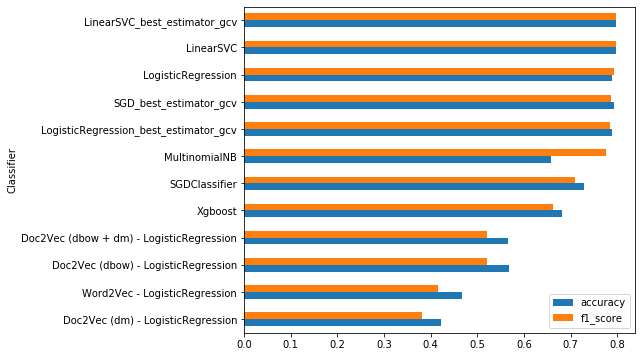

In [57]:
log.sort_values(by=['f1_score']).plot(kind='barh',figsize=[7,6])

In [58]:
from scipy import spatial
sentence = ['The job did not start this morning on time']
#get_concat_vectors(model_dbow,model_dm, len(X_train), 1200, 'Train')
#mod1 = model_dm.infer_vector(sentence.split())
#mod2 =  model_dbow.infer_vector(sentence.split())

#ind_vec = np.append(mod1,mod2)


#inferred_vector=model_dm.infer_vector(sentence.split())
print(encoder.inverse_transform(xgboost.predict(sentence)))
print(encoder.inverse_transform(logreg_1.predict(sentence)))

#enc.inverse_transform(encoded)

['GRP_8']
['GRP_8']


In [59]:

### Save the model
from sklearn.externals import joblib
joblib.dump(logreg_1, 'auto_ticket_assignment.pkl', compress=1)

['auto_ticket_assignment.pkl']

In [60]:
le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
le_name_mapping

{'GRP_0': 0,
 'GRP_10': 1,
 'GRP_12': 2,
 'GRP_13': 3,
 'GRP_14': 4,
 'GRP_19': 5,
 'GRP_2': 6,
 'GRP_24': 7,
 'GRP_25': 8,
 'GRP_3': 9,
 'GRP_33': 10,
 'GRP_5': 11,
 'GRP_6': 12,
 'GRP_8': 13,
 'GRP_9': 14}

In [61]:

from sklearn.externals import joblib
model = joblib.load('auto_ticket_assignment.pkl')

sentence = 'not able to connect to my system'
encoder.inverse_transform(model.predict([sentence]))

array(['GRP_0'], dtype=object)

# Finals Conclusions fo Approach1

- We first analysed the dataset provided to us, undestood the structure of the data provided - number of columns, field , datatypes etc.
- We did Exploratory Data Analysis to derive further insights from this data set and we found that
    - Data is very much imbalanced, there are around ~45% of the Groups with less than 20 tickets.
    - Few of the tickets are in foreign language like German
    - The data has lot of noise in it, for eg- few tickets related to account setup are spread across multiple assignment groups.
    
- We performed the data cleaning and preprocessing
    - Translation: A small number of tickets were written in German. Hence, we used the Google translate python api  to convert German to English to generate the input data for the next steps. However, the google translator rest api can only process a limited number of texts on a daily basis, so we translated the text in batches and saved the file for further processing.
    - Make text all lowercase so that the algorithm does not treat the same words in different cases as different
    - Removing Noise i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values
    - Removing extract spaces
    - Removed punctuations
    - Removed words containing numbers
    - Stopword Removal: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words
    - Lemmatization
    - Tokenization: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
    

- We then ran a basic benchmarck model using the cleaned and preprocessed dataset
    - Since the dataset is very imbalanced, We considered a subset of groups for predictions.  In 74 groups, 46% of tickets belong to group 1 and 16 groups just have more than 100 tickets, rest of the Assignment groups have very less ticket counts which might not add much value to the model prediction. If we conducted random sampling towards all the subcategories, then we would face a problem that we might miss all the tickets in some categories. Hence, we considered the groups that have more than 100 tickets. 
    - We trained the data using below models:
        - Multinomial NB
        - Linear Support vector Machine
        - Logistic regression
        - Xgboost
        
- LinearSVC gives better performance with 
    - accuracy 0.833642
    - f1 score 0.818053

<b> Although, it seems like the call is biased towards GRP_0 which has a majority of samples. </b>



- Even after downsampling the data we see that the predictions are biased towards GRP_0 which has a majority of samples.
- Imbalance causes two problems:
    - Training is inefficient as most samples are easy examples that contribute no useful learning signal;
    - The easy examples can overwhelm training and lead to degenerate models.
    A common solution is to perform some form of hard negative mining that samples hard examples during training or more complex sampling/re weighing schemes.In order to handle the imbalance problem  we used class_weight=balanced hyperparameter while training the model, which tells the model to "pay more attention" to samples from an under-represented class.  
- Although, the accuracy and f1_score went down. This ensured that the classes were being correctly classified with lesser number of missclassification and good precision/recall scores for all the classes

- Next, we also tried using pretrained word embedding, but the only challenge was that we could not find any embeddings trained on ITSM data. We used the glove model with 100d for this, and then used logistic regression and Xgboost to train the model. But, the scores were poorer than the benchmark model.
 
- Then, we also tried vector space modelling using Doc2Vec with DistributedBOW and Distributed Memory approach, though ‘Doc2Vec’ is a more advanced model in NLP rather than ‘Tf-Idf’, but still in our case, it is not giving proper results. We have tried with a linear  & boosting based classifier respectively.
  
  In our dataset, ‘texts’ are domain-specific. Furthermore, ‘Doc2Vec’ model is more suitable for very well written grammatically correct texts. In our case, texts are quite rough in nature.It is also proven in various examples and Data Sc ientist’s experiments that though ‘Tf-Idf’ model is inferior as compared to ‘Doc2Vec’, but still it gives better result while classifying very domain specific texts.
 
 
 - Linear SVC gave better performance with hyperparameter tuning and this model would be used for classifying the tickets into one of the groups.
    - accuracy 0.797441
    - f1 score 0.797100

The performance can be further improved by collecting more data for tickets and by running deep learning models like RNN and LSTM's.